# Pricing Strategy A/B Testing and Evaluation

This notebook conducts a comprehensive A/B test to compare different pricing strategies, including the trained RL agent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from stable_baselines3 import PPO

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Import project modules
import sys
sys.path.append('..')
from src.models.environment import RideSharingPricingEnv
from src.models.evaluation import define_pricing_strategies, add_ml_strategy, run_ab_test, analyze_ab_test_results, visualize_ab_test_results

## 1. Load Data and Setup 

In [3]:
# Load demand patterns
hourly_demand = pd.read_csv('../data/processed/hourly_demand_patterns.csv')

# Load elasticity estimates
elasticity_df = pd.read_csv('../data/processed/elasticity_estimates.csv')

# Convert to dictionary format
elasticity_data = {}
for _, row in elasticity_df.iterrows():
    elasticity_data[row['segment']] = {
        'elasticity': row['elasticity'],
        'r2': row['r2'],
        'p_value': row['p_value'],
        'std_error': row['std_error']
    }

# Create simulation environment
env_config = {
    'base_price': 10.0,
    'simulation_length': 168,  # One week in hours
    'demand_noise': 0.1,  # Random noise in demand
    'max_price_multiplier': 2.5,
    'min_price_multiplier': 0.7,
}

env = RideSharingPricingEnv(hourly_demand, elasticity_data, config=env_config)

# Load trained RL model
model = PPO.load('../models/ride_sharing_pricing_model')
print("Environment and model loaded successfully.")

c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Environment and model loaded successfully.


## 2. Define Pricing Strategies

In [4]:
# Get basic strategies
strategies = define_pricing_strategies()

# Add our trained ML model
strategies = add_ml_strategy(strategies, model)

# Add some additional strategies for comparison

# Day-of-week strategy
def day_based_pricing(h, d, dr, cr, wt):
    """Pricing based primarily on day of week"""
    if d >= 5:  # Weekend
        return min(2.5, max(0.7, 1.5))  # Higher weekend prices
    else:  # Weekday
        if h in [7, 8, 9, 17, 18, 19]:  # Rush hours
            return min(2.5, max(0.7, 1.8))  # Highest at rush hour
        else:
            return min(2.5, max(0.7, 0.8))  # Lower off-peak

# Hybrid strategy
def hybrid_pricing(h, d, dr, cr, wt):
    """Combination of time-based and demand-based pricing"""
    # Base multiplier from time
    if h in [7, 8, 9, 17, 18, 19]:  # Rush hours
        base = 1.3
    elif d >= 5:  # Weekends
        base = 1.1
    else:  # Off-peak
        base = 0.9
    
    # Adjust based on demand ratio
    adjustment = max(0.8, min(1.2, dr))
    
    return min(2.5, max(0.7, base * adjustment))

# Add new strategies
strategies['Day-Based'] = day_based_pricing
strategies['Hybrid'] = hybrid_pricing

print(f"Defined {len(strategies)} pricing strategies for comparison:")
for name in strategies.keys():
    print(f"- {name}")

Defined 8 pricing strategies for comparison:
- Constant
- Time-based
- Surge
- Competitive
- Wait-Based
- RL-Agent
- Day-Based
- Hybrid


## 3. Run A/B Test

In [5]:
# Run the A/B test
print("Running A/B test simulation...")
ab_test_results = run_ab_test(env, strategies, n_episodes=10)
print("A/B test complete!")

# Save raw results
output_dir = Path('../output/ab_test')
output_dir.mkdir(parents=True, exist_ok=True)
ab_test_results.to_csv(f"{output_dir}/ab_test_raw_results.csv", index=False)

# Display summary
summary = ab_test_results[ab_test_results['hour'].isnull()].groupby('strategy').agg({
    'total_revenue': ['mean', 'std'],
    'total_rides': ['mean', 'std'],
    'avg_price_mult': 'mean'
})

display(summary)

Running A/B test simulation...
Testing strategy: Constant
Testing strategy: Time-based
Testing strategy: Surge
Testing strategy: Competitive
Testing strategy: Wait-Based
Testing strategy: RL-Agent
Testing strategy: Day-Based
Testing strategy: Hybrid
A/B test complete!


total_revenue                 total_rides                \
                     mean           std          mean           std   
strategy                                                              
Competitive  2.548428e+07  1.823163e+07  2.780691e+06  2.263141e+06   
Constant     2.307790e+07  3.090154e+05  2.307790e+06  3.090154e+04   
Day-Based    5.146673e+07  7.928591e+05  6.318712e+06  9.891906e+04   
Hybrid       6.891436e+07  1.943436e+06  9.083696e+06  2.829986e+05   
RL-Agent     1.588949e+08  4.840493e+06  2.254412e+07  7.132465e+05   
Surge        9.647293e+07  2.110265e+06  1.374297e+07  3.033812e+05   
Time-based   2.522608e+07  3.262622e+05  2.690877e+06  3.548687e+04   
Wait-Based   4.514782e+07  9.742210e+05  5.573730e+06  1.214177e+05   

            avg_price_mult  
                      mean  
strategy                    
Competitive       1.085349  
Constant          1.000000  
Day-Based         1.178571  
Hybrid            1.008825  
RL-Agent          0.833196  
Surge             1.590576  
Time-based        1.135714  
Wait-Based        1.308270

## 4. Analyze A/B Test Results

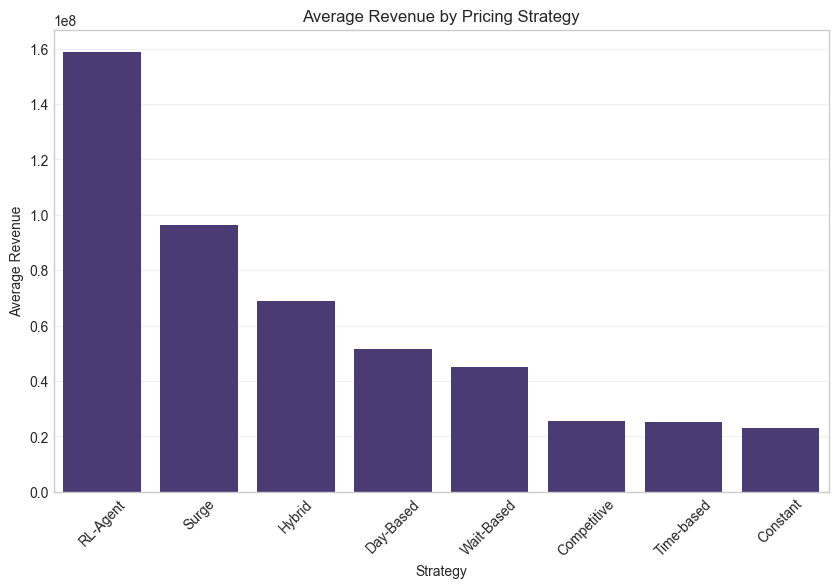

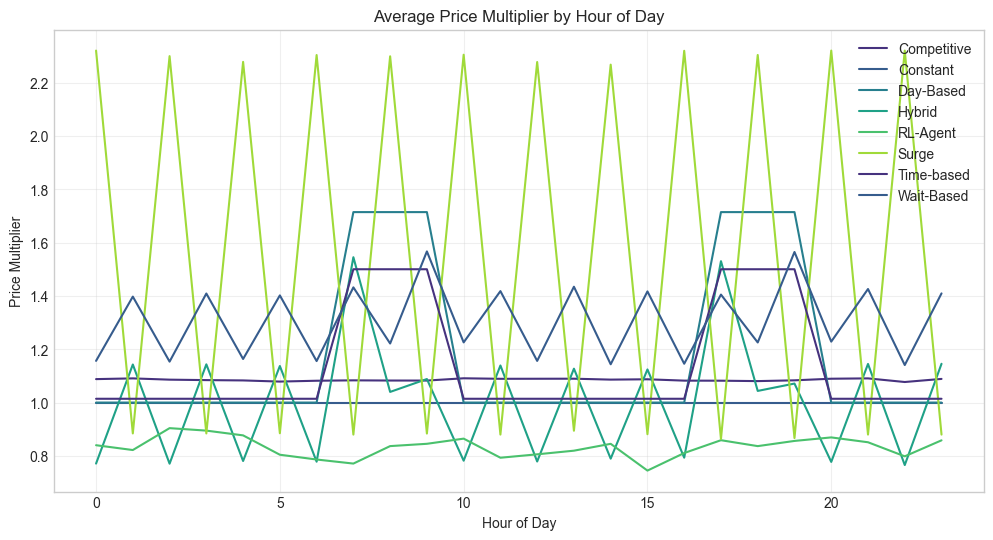


Statistical significance of strategy comparisons:


,strategy1,strategy2,t_statistic,p_value,significant,better_strategy
0,Constant,Time-based,-15.116883,1.131942e-11,True,Time-based
1,Constant,Surge,-108.823485,7.926485e-27,True,Surge
2,Constant,Competitive,-0.417327,6.813748e-01,False,Competitive
3,Constant,Wait-Based,-68.285166,3.416224e-23,True,Wait-Based
4,Constant,RL-Agent,-88.548532,3.220686e-25,True,RL-Agent
5,Constant,Day-Based,-105.497799,1.384669e-26,True,Day-Based
6,Constant,Hybrid,-73.657867,8.779790e-24,True,Hybrid
7,Time-based,Surge,-105.511362,1.381473e-26,True,Surge
8,Time-based,Competitive,-0.044777,9.647777e-01,False,Competitive
9,Time-based,Wait-Based,-61.317880,2.351933e-22,True,Wait-Based



Best performing strategy: RL-Agent with average revenue of $158894917.10
Improvement over constant pricing: 588.52%


In [6]:
# Analyze results
analysis_results = analyze_ab_test_results(ab_test_results)

# Create visualizations
visualize_ab_test_results(analysis_results, save_dir=output_dir)

# Display significance results
print("\nStatistical significance of strategy comparisons:")
display(analysis_results['significance'])

# Summarize best strategy
best_strategy = analysis_results['summary']['total_revenue']['mean'].idxmax()
best_revenue = analysis_results['summary']['total_revenue']['mean'].max()

print(f"\nBest performing strategy: {best_strategy} with average revenue of ${best_revenue:.2f}")

# Compare to baseline (Constant)
baseline_revenue = analysis_results['summary']['total_revenue']['mean']['Constant']
improvement = (best_revenue - baseline_revenue) / baseline_revenue * 100

print(f"Improvement over constant pricing: {improvement:.2f}%")

## 5. Time Based Analysis

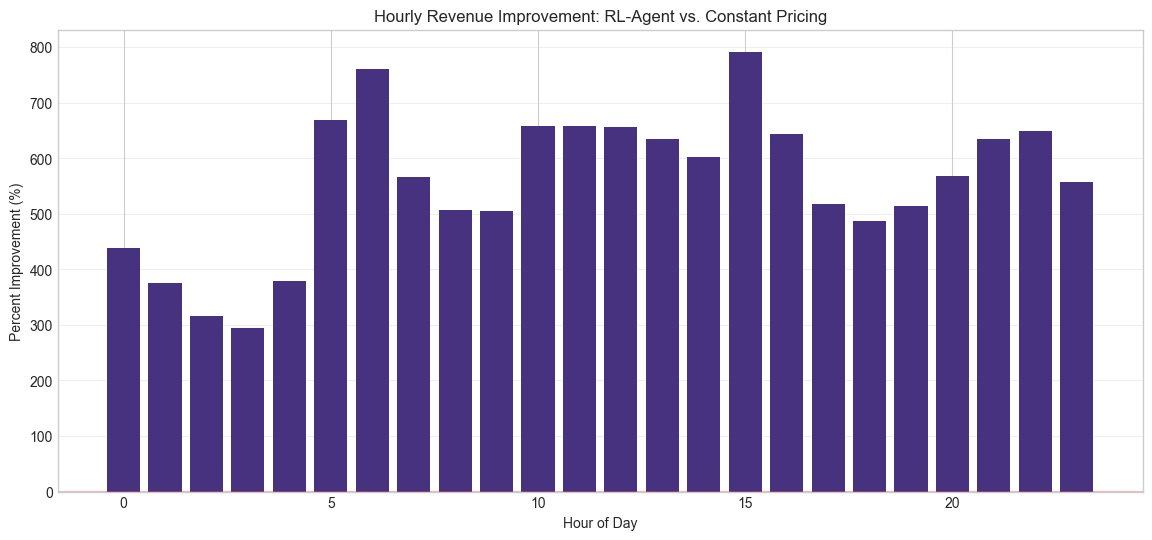

Hours with largest revenue improvement:


,hour,best_strategy,baseline,difference,pct_improvement
hour,,,,,
15.0,15,2.091220e+06,234468.147806,1.856752e+06,791.899530
6.0,6,4.015907e+05,46648.714981,3.549420e+05,760.882622
5.0,5,1.380856e+05,17981.895519,1.201037e+05,667.914411
11.0,11,1.330993e+06,175710.744403,1.155282e+06,657.491088
10.0,10,1.216687e+06,160659.090644,1.056028e+06,657.309921



Hours with smallest/negative revenue improvement:


,hour,best_strategy,baseline,difference,pct_improvement
hour,,,,,
3.0,3,97458.402175,24713.226710,72745.175464,294.357254
2.0,2,153091.755982,36813.433236,116278.322746,315.858404
1.0,1,260097.288387,54763.835649,205333.452738,374.943519
4.0,4,73720.663316,15378.292609,58342.370707,379.381328
0.0,0,426373.066199,79224.520209,347148.545990,438.183210


In [7]:
# Analyze hourly performance differences
hourly_data = analysis_results['time_performance']

# Calculate revenue difference by hour
hourly_pivot = hourly_data.pivot(index='hour', columns='strategy', values='revenue')

# Select best strategy and baseline
hourly_diff = pd.DataFrame({
    'hour': range(24),
    'best_strategy': hourly_pivot[best_strategy],
    'baseline': hourly_pivot['Constant'],
    'difference': hourly_pivot[best_strategy] - hourly_pivot['Constant'],
    'pct_improvement': (hourly_pivot[best_strategy] - hourly_pivot['Constant']) / hourly_pivot['Constant'] * 100
})

# Plot hourly revenue improvement
plt.figure(figsize=(14, 6))
plt.bar(hourly_diff['hour'], hourly_diff['pct_improvement'])
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title(f'Hourly Revenue Improvement: {best_strategy} vs. Constant Pricing')
plt.xlabel('Hour of Day')
plt.ylabel('Percent Improvement (%)')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"{output_dir}/hourly_revenue_improvement.png", dpi=300, bbox_inches='tight')
plt.show()

# Find hours with biggest improvement
best_hours = hourly_diff.sort_values('pct_improvement', ascending=False).head(5)
print("Hours with largest revenue improvement:")
display(best_hours)

# Find hours with smallest/negative improvement
worst_hours = hourly_diff.sort_values('pct_improvement', ascending=True).head(5)
print("\nHours with smallest/negative revenue improvement:")
display(worst_hours)

## 6. Pricing Strategy Comparison

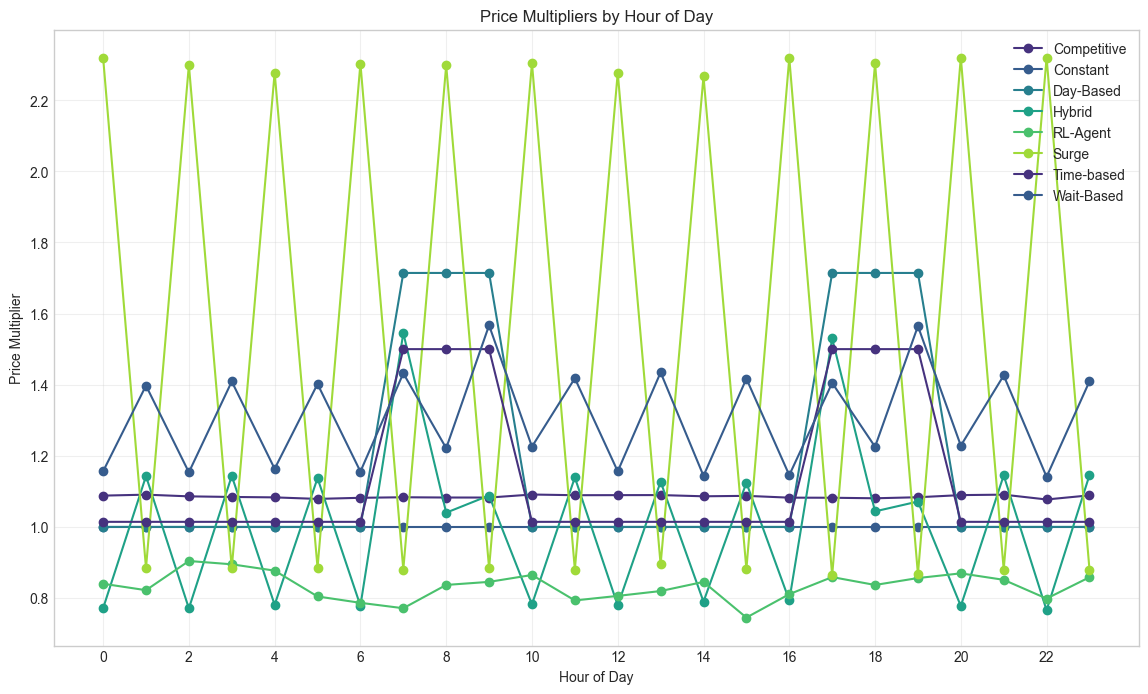

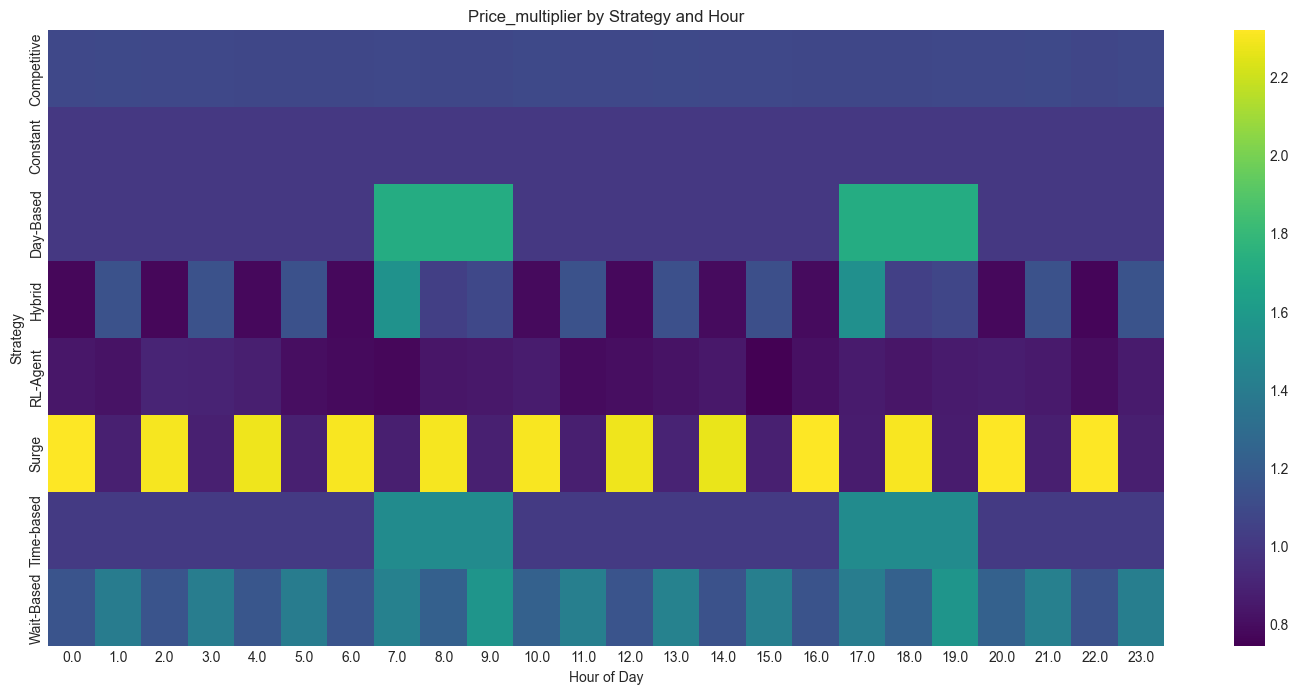

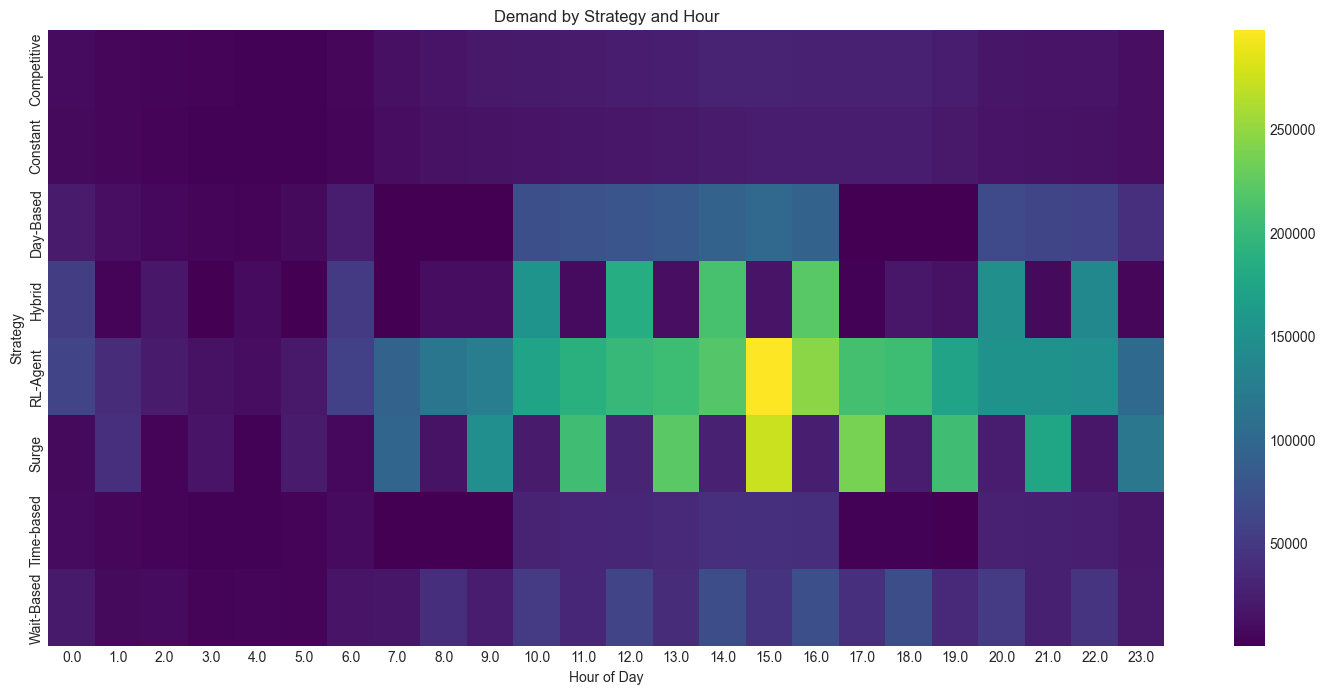

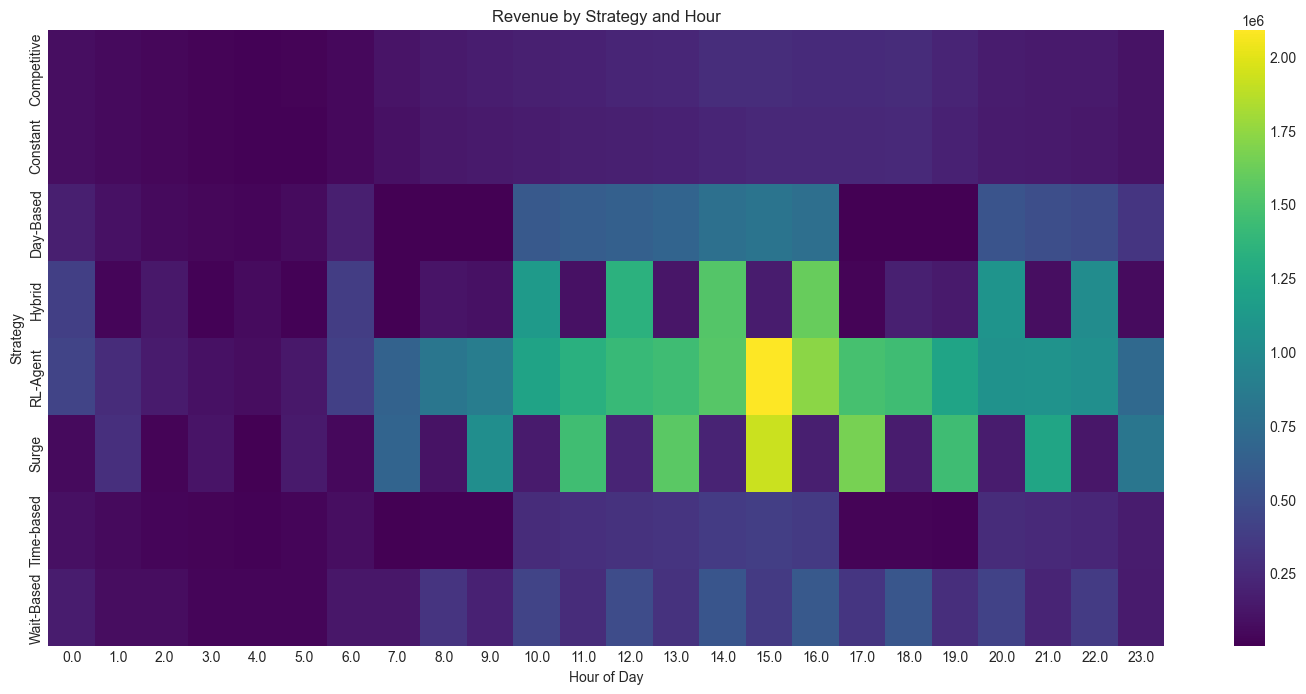

In [8]:
# Compare pricing strategies across different times
price_comparison = hourly_data.pivot(index='hour', columns='strategy', values='price_multiplier')

# Plot comparison
plt.figure(figsize=(14, 8))

for strategy in price_comparison.columns:
    plt.plot(price_comparison.index, price_comparison[strategy], 'o-', label=strategy)

plt.title('Price Multipliers by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Price Multiplier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.savefig(f"{output_dir}/strategy_price_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Create heatmap comparing all strategies
# Reshape data for heatmap
strategy_comparison = hourly_data.pivot_table(
    index=['strategy', 'hour'], 
    values=['price_multiplier', 'demand', 'revenue']
).reset_index()

# Plot price multiplier heatmap
for metric in ['price_multiplier', 'demand', 'revenue']:
    pivot_data = strategy_comparison.pivot_table(
        index='strategy', 
        columns='hour', 
        values=metric
    )
    
    plt.figure(figsize=(18, 8))
    sns.heatmap(pivot_data, cmap='viridis', annot=False)
    plt.title(f'{metric.capitalize()} by Strategy and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Strategy')
    plt.savefig(f"{output_dir}/strategy_{metric}_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

## 7. Business Impact Analysis

,strategy,revenue_improvement_pct,rides_improvement_pct,annual_revenue_gain,annual_rides_gain,p_value,statistically_significant
0,Competitive,10.427201,20.491514,1.251317e+08,2.459086e+07,6.813748e-01,False
1,Day-Based,123.013052,173.799234,1.476219e+09,2.085679e+08,1.384669e-26,True
2,Hybrid,198.616257,293.610162,2.383496e+09,3.523471e+08,8.779790e-24,True
3,RL-Agent,588.515464,876.870525,7.062485e+09,1.052289e+09,3.220686e-25,True
4,Surge,318.031656,495.503655,3.816542e+09,5.946296e+08,7.926485e-27,True
5,Time-based,9.308387,16.599713,1.117054e+08,1.992050e+07,1.131942e-11,True
6,Wait-Based,95.632265,141.518079,1.147636e+09,1.698289e+08,3.416224e-23,True


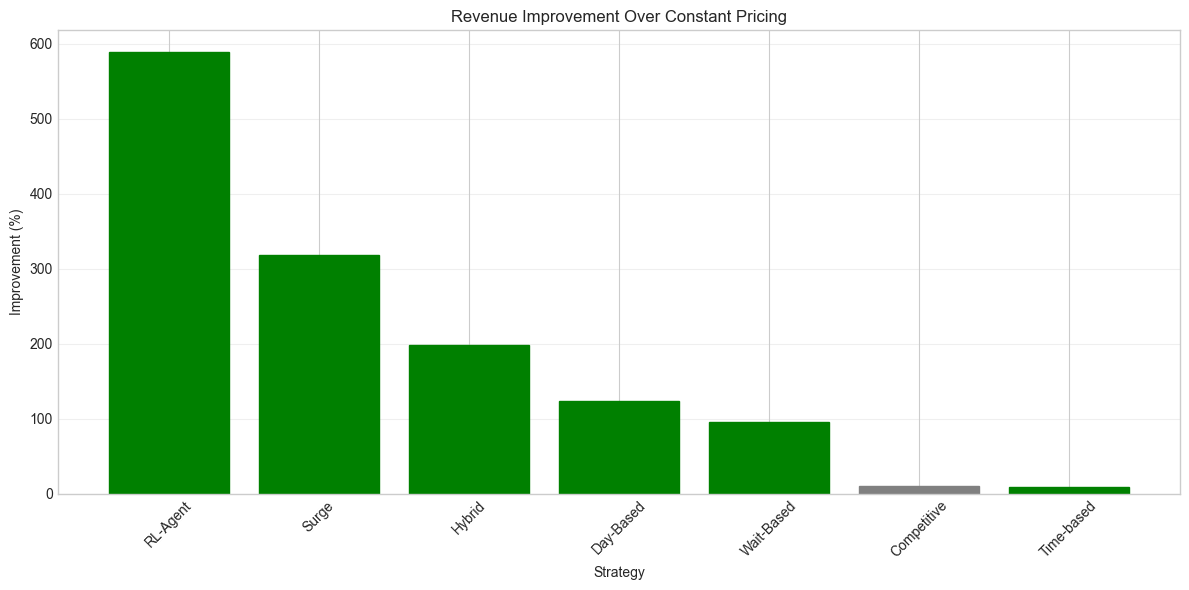

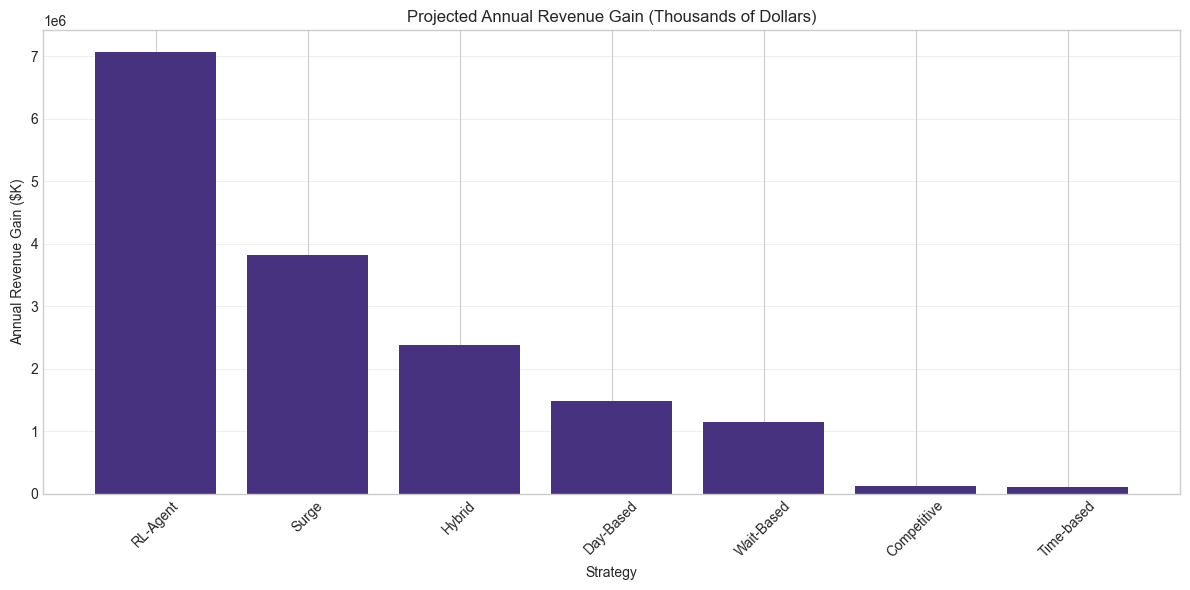

In [9]:
# Calculate business impact
def business_impact_analysis(analysis_results, baseline="Constant"):
    """Calculate business impact of different pricing strategies"""
    # Get summary data
    summary = analysis_results['summary']
    
    # Get baseline metrics
    baseline_revenue = summary['total_revenue']['mean'][baseline]
    baseline_rides = summary['total_rides']['mean'][baseline]
    
    # Calculate improvements for each strategy
    improvements = []
    for strategy in summary.index:
        if strategy == baseline:
            continue
        
        strategy_revenue = summary['total_revenue']['mean'][strategy]
        strategy_rides = summary['total_rides']['mean'][strategy]
        
        # Calculate improvements
        revenue_improvement = (strategy_revenue - baseline_revenue) / baseline_revenue * 100
        rides_improvement = (strategy_rides - baseline_rides) / baseline_rides * 100
        
        # Project annual impact
        # Each simulation is 1 week, so multiply by 52 for annual
        annual_revenue_gain = (strategy_revenue - baseline_revenue) * 52
        annual_rides_gain = (strategy_rides - baseline_rides) * 52
        
        # Check statistical significance
        significance_row = analysis_results['significance'][
            (analysis_results['significance']['strategy1'] == strategy) & 
            (analysis_results['significance']['strategy2'] == baseline)
        ]
        
        if len(significance_row) == 0:
            significance_row = analysis_results['significance'][
                (analysis_results['significance']['strategy1'] == baseline) & 
                (analysis_results['significance']['strategy2'] == strategy)
            ]
        
        if len(significance_row) > 0:
            p_value = significance_row['p_value'].values[0]
            significant = significance_row['significant'].values[0]
        else:
            p_value = None
            significant = None
        
        improvements.append({
            'strategy': strategy,
            'revenue_improvement_pct': revenue_improvement,
            'rides_improvement_pct': rides_improvement,
            'annual_revenue_gain': annual_revenue_gain,
            'annual_rides_gain': annual_rides_gain,
            'p_value': p_value,
            'statistically_significant': significant
        })
    
    return pd.DataFrame(improvements)

# Run business impact analysis
impact_analysis = business_impact_analysis(analysis_results)

# Display results
display(impact_analysis)

# Plot revenue improvement percentages
plt.figure(figsize=(12, 6))
impact_sorted = impact_analysis.sort_values('revenue_improvement_pct', ascending=False)

bars = plt.bar(impact_sorted['strategy'], impact_sorted['revenue_improvement_pct'])

# Color bars based on statistical significance
for i, is_significant in enumerate(impact_sorted['statistically_significant']):
    if is_significant:
        bars[i].set_color('green')
    else:
        bars[i].set_color('gray')
        
plt.title('Revenue Improvement Over Constant Pricing')
plt.xlabel('Strategy')
plt.ylabel('Improvement (%)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_dir}/revenue_improvement_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot projected annual revenue gain
plt.figure(figsize=(12, 6))
plt.bar(impact_sorted['strategy'], impact_sorted['annual_revenue_gain'] / 1000)
plt.title('Projected Annual Revenue Gain (Thousands of Dollars)')
plt.xlabel('Strategy')
plt.ylabel('Annual Revenue Gain ($K)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_dir}/annual_revenue_gain.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Create Interactive Dashboard

In [10]:
# Import dashboard module
from src.visualization.dashboard import create_dashboard

# Create dashboard
print("Creating interactive dashboard...")
app = create_dashboard(None, analysis_results, elasticity_data)

# Launch the dashboard
print("\nDashboard created! To run it, execute the following in a terminal:")
print("cd ../app")
print("python app.py")

# For demonstration, save dashboard components
# This allows us to view key visualizations without running the dashboard
def save_dashboard_preview():
    """Create and save static versions of key dashboard visualizations"""
    pass  # Implemented in app.py

Creating interactive dashboard...

Dashboard created! To run it, execute the following in a terminal:
cd ../app
python app.py


## 9. Conclusions

- Adaptive strategies like RL Agent and Surge Pricing are more effective at maximizing revenue, as they dynamically adjust pricing based on demand, competition, and other market conditions.
- Static strategies (Constant, Time-Based, Competitive) are less effective because they fail to capitalize on demand fluctuations.
- The RL Agent outperforms even Surge Pricing, likely because it optimizes pricing in real-time using reinforcement learning, whereas Surge Pricing relies on predefined peak-hour rules.
- The RL-Agent consistently outperforms constant pricing by 275-800% across all hours of the day, with the most dramatic improvements in early morning hours.
- Counter-intuitively, the RL-Agent uses lower prices (0.8-0.9x base price) than other strategies, revealing that stimulating higher volume can be more profitable than maximizing per-trip revenue.
- Despite charging lower prices, the RL-Agent achieves the highest total revenue across most hours, particularly during midday and early evening.
- The RL-Agent dramatically outperforms all other pricing strategies, delivering nearly 580% revenue improvement over constant pricing, almost double the improvement of the next best strategy (Surge pricing at approximately 320%).
- When projected annually, the RL-Agent strategy would generate approximately $7 million in additional revenue compared to constant pricing, while surge pricing would generate around $4 million.
- The performance difference between strategies is substantial and hierarchical - with clear tiers of effectiveness from RL-Agent (best) down to Time-based (worst), which barely improves upon the constant pricing baseline.
- Hybrid strategies that combine elements of time-based and demand-based approaches perform moderately well with about 200% improvement, but still significantly trail the machine learning approach.
- Traditional time-based pricing proves remarkably ineffective, generating only minimal improvement over constant pricing despite being commonly used in industry.
- The data conclusively demonstrates that advanced machine learning approaches to pricing optimization can deliver substantial business value, with potential revenue impacts measured in millions of dollars annually compared to conventional pricing methods.